<a href="https://colab.research.google.com/github/fxnnxc/class-MachineLearning/blob/master/Assignment09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment09 

Multi-label classification using neural networks

## I. Codes

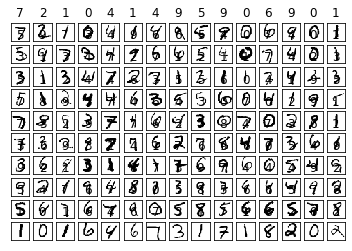

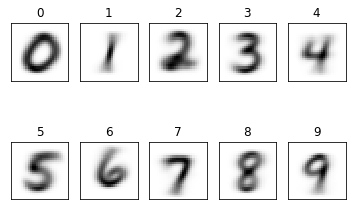

In [1]:
import matplotlib.pyplot as plt
import numpy as np

file_data   = "/content/drive/My Drive/Classroom/Machine Learning (1) 2020-1/mnist.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines()
handle_file.close()

size_row    = 28    # height of the image
size_col    = 28    # width of the image

num_image   = len(data)
count       = 0     # count for the number of images

#
# normalize the values of the input data to be [0, 1]
#
def normalize(data):

    data_normalized = (data - min(data)) / (max(data) - min(data))

    return(data_normalized)

#
# example of distance function between two vectors x and y
#
def distance(x, y):

    d = (x - y) ** 2
    s = np.sum(d)
    # r = np.sqrt(s)

    return(s)

#
# make a matrix each column of which represents an images in a vector form
#
list_image  = np.empty((size_row * size_col, num_image), dtype=float)
list_label  = np.empty(num_image, dtype=int)

for line in data:

    line_data   = line.split(',')
    label       = line_data[0]
    im_vector   = np.asfarray(line_data[1:])
    im_vector   = normalize(im_vector)

    list_label[count]       = label
    list_image[:, count]    = im_vector

    count += 1

#
# plot first 150 images out of 10,000 with their labels
#
f1 = plt.figure(1)

for i in range(150):

    label       = list_label[i]
    im_vector   = list_image[:, i]
    im_matrix   = im_vector.reshape((size_row, size_col))

    plt.subplot(10, 15, i+1)
    plt.title(label)
    plt.imshow(im_matrix, cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)


#plt.show()

#
# plot the average image of all the images for each digit
#
f2 = plt.figure(2)

im_average  = np.zeros((size_row * size_col, 10), dtype=float)
im_count    = np.zeros(10, dtype=int)

for i in range(num_image):

    im_average[:, list_label[i]] += list_image[:, i]
    im_count[list_label[i]] += 1

for i in range(10):

    im_average[:, i] /= im_count[i]

    plt.subplot(2, 5, i+1)
    plt.title(i)
    plt.imshow(im_average[:,i].reshape((size_row, size_col)), cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)

plt.show()


In [0]:
def one_hot(y):
  oneHotY = np.zeros((10, len(y)))
  for i in range(len(y)):
    oneHotY[y[i]][i] = 1
  return oneHotY


X_train = list_image[:,:6000]
X_test  = list_image[:,6000:]
y_train = one_hot(list_label[:6000])
y_test  = one_hot(list_label[6000:])

$J(\theta) = {1 \over M} \sum (l*log(h) - (1-l) log(1-h))$

$\theta_i = \theta_i - \alpha( \sum{(\sigma - Label)*x_i} )$

 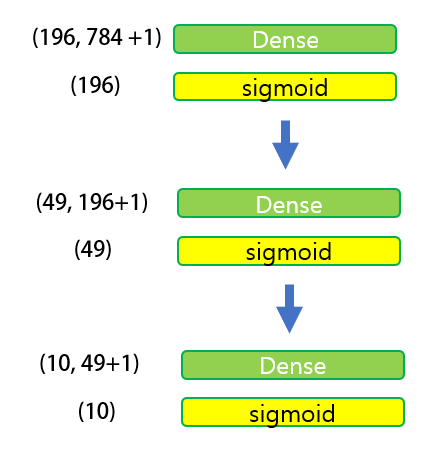



In [0]:

lr = 0.001

# Shapes
input_size  = 784 
layer1_size = 196 
layer2_size = 49 
output_size = 10

# Weights
layer1 = np.random.normal(0,1,(layer1_size, input_size+1))   # With bias
layer2 = np.random.normal(0,1,(layer2_size, layer1_size+1))  # With bias
outlay = np.random.normal(0,1,(output_size, layer2_size+1))  # With bias

# stores
loss_train = []
loss_test  = []
acc_train  = []
acc_test   = []

In [0]:
# Utilities

def loss(X, y,a , return_dict):
  H = forward(X)
  return_dict[a] = np.sum(-np.multiply(y, np.log(H)) - np.multiply(1-y, np.log(1-H)))

def calculate_acc(x_tr, y_tr,a , return_dict):
  train = forward(x_tr)
  count= 0
  for h in range(train.shape[1]):
    lst =  [(i,j) for i,j in enumerate(train[:,h])]
    lst = sorted(lst , key= lambda x: -x[1])
    index = lst[0][0]
    if y_tr[index,h] ==1:
      count+=1

  return_dict[a] = count/train.shape[1]*100


In [0]:
# Functions

def sigmoid(x):
  return 1/(1+np.exp(-x))

def train(x, y):
    global outlay, layer1, layer2
   # Layer 1
    output = np.concatenate((x, np.ones((1, len(x[0])))), axis=0)
    value1 = output
    output = np.dot(layer1, output) 
    output = sigmoid(output)

    # Layer 2
    output = np.concatenate((output, np.ones((1,len(output[0])))), axis=0)   
    value2 = output
    output = np.dot(layer2, output)
    output = sigmoid(output)
    
    # Output layer
    output = np.concatenate((output, np.ones((1,len(output[0])))), axis=0)
    value3 = output
    output = np.dot(outlay, output)
    output = sigmoid(output)

    # Backward
    temp1 = np.mean(np.dot(output - y, value3.T ))
    temp2 = np.mean(np.dot(temp1, value2.T))
    temp3 = np.mean(np.dot(temp2, value1.T))

    outlay -= lr * temp1
    layer2 -= lr * temp2
    layer1 -= lr * temp3

    return output

def forward(x):
    global outlay, layer1, layer2
    # Layer 1
    output = np.concatenate((x, np.ones((1, len(x[0])))), axis=0)
    output = np.dot(layer1, output) 
    output = sigmoid(output)

    # Layer 2
    output = np.concatenate((output, np.ones((1,len(output[0])))), axis=0)   
    output = np.dot(layer2, output)
    output = sigmoid(output)
    
    # Output layer
    output = np.concatenate((output, np.ones((1,len(output[0])))), axis=0)
    output = np.dot(outlay, output)
    output = sigmoid(output)

    return output

In [63]:
from multiprocessing import Process, Manager

COUNT = 100
PRINT = COUNT //10
manager = Manager()
return_dict = manager.dict()

for c in range(COUNT):
  if c%PRINT ==0:
    print(c*100//COUNT)
  train(X_train, y_train)
  procs = [Process(target=loss, args=(X_train, y_train,0, return_dict)),
             Process(target=loss, args=(X_test, y_test,1, return_dict)),
             Process(target=calculate_acc, args=(X_train, y_train, 2, return_dict)),
             Process(target=calculate_acc, args=(X_test, y_test, 3, return_dict))]

  for proc in procs:
    proc.start()
  for proc in procs:
    proc.join()

  loss_train.append(return_dict.values()[0])
  loss_test.append(return_dict.values()[1])
  acc_train.append(return_dict.values()[2])
  acc_test.append(return_dict.values()[3])
  

0
10
20
30
40
50
60
70
80
90


## II. Results

1. Plot the loss curve

plot the training loss at every iteration of gradient descent using the training data in blue color (the first 6,000 images) [5pt]

plot the testing loss at every iteration of gradient descent using the testing data in red color (the rest 4,000 images) [5pt]

the both curves should be presented in one figure



Text(0.5, 1.0, 'Loss Curve')

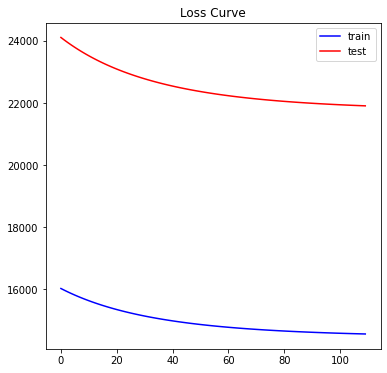

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.plot(loss_train, color='b')
plt.plot(loss_test,  color='r')
plt.legend(['train', 'test'])
plt.title('Loss Curve')

2. Plot the accuracy curve

plot the training accuracy (%) at every iteration of gradient descent using the training data in blue color (the first 6,000 images) [5pt]

plot the testing accuracy (%) at every iteration of gradient descent using the testing data in red color (the rest 4,000 images) [5pt]

the both curves should be presented in one figure

Text(0.5, 1.0, 'Accuracy Curve')

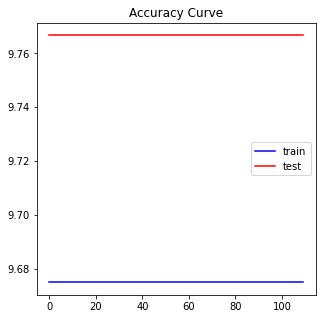

In [65]:
plt.figure(figsize=(5,5))
plt.plot(acc_train, color='b')
plt.plot(acc_test , color='r')
plt.legend(['train', 'test'])
plt.title('Accuracy Curve')

3. Plot the accuracy value

print the final training accuracy (%) using the training data (the first 6,000 images) [2pt]

print the final testing accuracy (%) using the testing data (the rest 4,000 images) [2pt]

In [66]:
from termcolor import colored

print(colored(f"Final Training Accuracy Of Train Data : {acc_train[-1]:.1f}%", 'red'))
print(colored(f"Final Training Accuracy Of Test  Data : {acc_test[-1]:.1f}%", 'blue'))

Final Training Accuracy Of Train Data : 9.7%
Final Training Accuracy Of Test  Data : 9.8%


4. Plot the classification example

present 10 correctly classified testing images with their labels at the title of each sub-figure in 2x5 array [5pt]

present 10 misclassified testing images with their misclassified labels at the title of each sub-figure in 2x5 array [5pt]